In the `intro_predecessor.ipynb` notebook, the $predecessor$ problem is quite simple and does not showcase the
capabilities of **Lernd**.

For a more difficult problem, let's solve $even$ and give it a mislabeled example. **Lernd** should learn the relation
given just a successor predicate $succ$ and examples, one of which will be incorrectly labelled.

Another way in which it is not a trivial problem, is that **Lernd** has to invent an auxiliary predicate to solve it,
and furthermore, there's recursion in the solution. An example solution could be:

$target(A) \leftarrow zero(A)$
$target(A) \leftarrow target(B),pred(B,A)$
$pred(A,B) \leftarrow succ(A,C),succ(C,B)$

Here $pred$ is the auxiliary predicate, true if $A+2=B$.


Let's define the problem:

In [7]:
import os
import tensorflow as tf
from lernd.classes import LanguageModel, ProgramTemplate, ILP
from lernd.lernd_loss import Lernd
from lernd.lernd_types import Constant, RuleTemplate
from lernd.main import generate_weight_matrices, extract_definitions, print_valuations
from lernd.util import str2pred, str2ground_atom, ground_atom2str, get_ground_atom_probs

os.environ['CUDA_VISIBLE_DEVICES'] = ''

target_pred = str2pred('even/1')
zero_pred = str2pred('zero/1')
succ_pred = str2pred('succ/2')
preds_ext = [zero_pred, succ_pred]
constants = [Constant(str(i)) for i in range(11)]
language_model = LanguageModel(target_pred, preds_ext, constants)

# Program template
aux_pred = str2pred('pred/2')
aux_preds = [aux_pred]
rules = {
    target_pred: (RuleTemplate(0, False), RuleTemplate(1, True)),
    aux_pred: (RuleTemplate(1, False), None)
}
forward_chaining_steps = 6
program_template = ProgramTemplate(aux_preds, rules, forward_chaining_steps)

# ILP problem
ground_zero = str2ground_atom('zero(0)')
background = [ground_zero] + [str2ground_atom(f'succ({i},{i + 1})') for i in range(10)]
positive = [str2ground_atom(f'even({i})') for i in range(0, 11, 2)]
negative = [str2ground_atom(f'even({i})') for i in range(1, 10, 2)]

Let's see the positive and negative examples:

In [8]:
print('Positive examples:')
print(', '.join(map(ground_atom2str, positive)))

print('\nNegative examples:')
print(', '.join(map(ground_atom2str, negative)))

Positive examples:
even(0), even(2), even(4), even(6), even(8), even(10)

Negative examples:
even(1), even(3), even(5), even(7), even(9)


Let's put one of the examples in the wrong category:

In [9]:
positive.append(negative.pop())

print('Positive examples:')
print(', '.join(map(ground_atom2str, positive)))

print('\nNegative examples:')
print(', '.join(map(ground_atom2str, negative)))

Positive examples:
even(0), even(2), even(4), even(6), even(8), even(10), even(9)

Negative examples:
even(1), even(3), even(5), even(7)


Standard ILP frameworks would not find the solution given such imperfect examples. One incorrect fact is enough to infer
anything. **Lernd** as a $\partial$ILP framework can have some success as it is minimizing loss, rather than satisfying
strict requirements.

Disclaimer: it does not succeed 100% of the time. According to the original paper, however, the percentage, where $even$
achieves less than 1e-4 mean squared test error *without noise*, is 48.5 %. Then again, they don't explain how exactly
they calculate MSE.

We can now finish defining the problem and run **Lernd**:

In [10]:
ilp_problem = ILP(language_model, background, positive, negative)
lernd_model = Lernd(ilp_problem, program_template, mini_batch=0.3)  # use 30% of examples in every training step
weights = generate_weight_matrices(lernd_model.clauses)

losses = []
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.5)

im = None
for i in range(1, 501):
    loss_grad, loss, valuation, full_loss = lernd_model.grad(weights)
    optimizer.apply_gradients(zip(loss_grad, list(weights.values())))
    loss_float = float(full_loss.numpy())
    mb_loss_float = float(loss.numpy())
    losses.append(loss_float)
    if i % 10 == 0:
        print(f'Step {i} loss: {loss_float}, mini_batch loss: {mb_loss_float}\n')

Generating clauses...
Generating ground atoms...
Making big lambda...
Generating initial valuation...
Initializing Inferrer
Inferrer initializing xc tensors...
Step 10 loss: 0.7429359555244446, mini_batch loss: 0.4950571060180664

Step 20 loss: 0.7290857434272766, mini_batch loss: 0.8217357993125916

Step 30 loss: 0.6139991283416748, mini_batch loss: 0.9958378672599792

Step 40 loss: 0.6211042404174805, mini_batch loss: 0.3267489969730377

Step 50 loss: 0.5755727291107178, mini_batch loss: 0.6369569897651672

Step 60 loss: 0.6292808055877686, mini_batch loss: 0.6171702146530151

Step 70 loss: 1.032448410987854, mini_batch loss: 1.2014769315719604

Step 80 loss: 0.5940074324607849, mini_batch loss: 0.3866165578365326

Step 90 loss: 0.5940332412719727, mini_batch loss: 0.6373648047447205

Step 100 loss: 0.6108120083808899, mini_batch loss: 0.730179488658905

Step 110 loss: 0.5538926720619202, mini_batch loss: 0.4050995409488678

Step 120 loss: 0.5902472138404846, mini_batch loss: 1.17010

Let's plot the loss to see how it went.

Text(0, 0.5, 'Value')

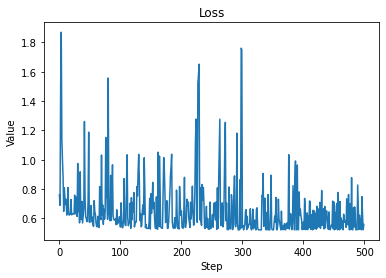

In [11]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_title('Loss')
ax.set_xlabel('Step')
ax.set_ylabel('Value')

Finally let's extract the results:

In [12]:
extract_definitions(lernd_model.clauses, weights)
ground_atom_probs = get_ground_atom_probs(valuation, lernd_model.ground_atoms)
print_valuations(ground_atom_probs)

clause_prob_threshold: 0.1

Clause learnt:
With probability (confidence): 0.3529891073703766
pred(A,B)<-succ(B,A), succ(C,B)

clause_prob_threshold: 0.1

Clause learnt:
With probability (confidence): 0.2738669514656067
even(A)<-zero(A), zero(A)
even(A)<-pred(B,A), succ(B,A)
With probability (confidence): 0.42311692237854004
even(A)<-zero(A), zero(A)
even(A)<-pred(B,B), succ(B,A)

Valuations of ground atoms (only those >0.01 for readability):
zero(0) - 1.0
succ(0,1) - 1.0
succ(1,2) - 1.0
succ(2,3) - 1.0
succ(3,4) - 1.0
succ(4,5) - 1.0
succ(5,6) - 1.0
succ(6,7) - 1.0
succ(7,8) - 1.0
succ(8,9) - 1.0
succ(9,10) - 1.0
pred(1,0) - 0.13843530416488647
pred(1,1) - 0.2076275646686554
pred(1,2) - 0.21504029631614685
pred(2,1) - 0.951917827129364
pred(2,2) - 0.2076275646686554
pred(2,3) - 0.21504029631614685
pred(3,2) - 0.951917827129364
pred(3,3) - 0.2076275646686554
pred(3,4) - 0.21504029631614685
pred(4,3) - 0.951917827129364
pred(4,4) - 0.2076275646686554
pred(4,5) - 0.21504029631614685
pred(

Obviously, this is a simple problem with no noise in the data, so the next notebook will demonstrate how lernd solves a
more difficult problem.